In [1]:
import math
import os
import sys
sys.path.insert(0,'..')
from citylearn.utilities import read_json
from doe_xstock.data import CityLearnData
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from src.utilities import DataHandler, FileHandler

In [2]:
BLDG_NAME = '481052'
FIGURES_DIRECTORY = os.path.join(FileHandler.FIGURES_DIRECTORY, 'ashrae_winter_conference_2024')
os.makedirs(FIGURES_DIRECTORY, exist_ok=True)

temperature_delta                                \
                                 count      mean       std       min   
bldg_name bldg_index                                                   
481052    2                     1416.0 -0.147462  0.801878 -2.315773   
20199     1                     1416.0  0.753497  0.940923 -1.457857   
75252     5                     1416.0  0.973066  0.737494 -1.348934   
199613    4                     1416.0  1.035425  0.479074 -0.274200   
498771    3                     1416.0 -1.040236  0.872320 -3.784149   
546814    6                     1416.0  1.055276  1.338952 -2.525339   
4421      7                     1416.0  1.280231  0.960242 -1.043377   
247942    0                     1416.0 -1.499594  0.588541 -3.280573   
79194     9                     1416.0 -1.546488  1.347720 -5.024456   
508889    8                     1416.0  1.628766  0.983141 -1.006252   

                                                                            
                           25%       50%       75%       max absolute_mean  
bldg_name bldg_index                                                        
481052    2          -0.673288 -0.179438  0.284310  2.778759      0.147462  
20199     1           0.016382  0.648612  1.334458  3.426865      0.753497  
75252     5           0.460406  0.894575  1.512588  3.436861      0.973066  
199613    4           0.734193  1.050714  1.341356  2.242197      1.035425  
498771    3          -1.616203 -1.063605 -0.461614  1.304869      1.040236  
546814    6           0.143780  0.815137  1.834914  6.177240      1.055276  
4421      7           0.587668  1.192574  1.988120  4.977325      1.280231  
247942    0          -1.916014 -1.525117 -1.145507  0.732405      1.499594  
79194     9          -2.525015 -1.661343 -0.721356  3.127998      1.546488  
508889    8           1.045824  1.515444  2.212694  4.841211      1.628766

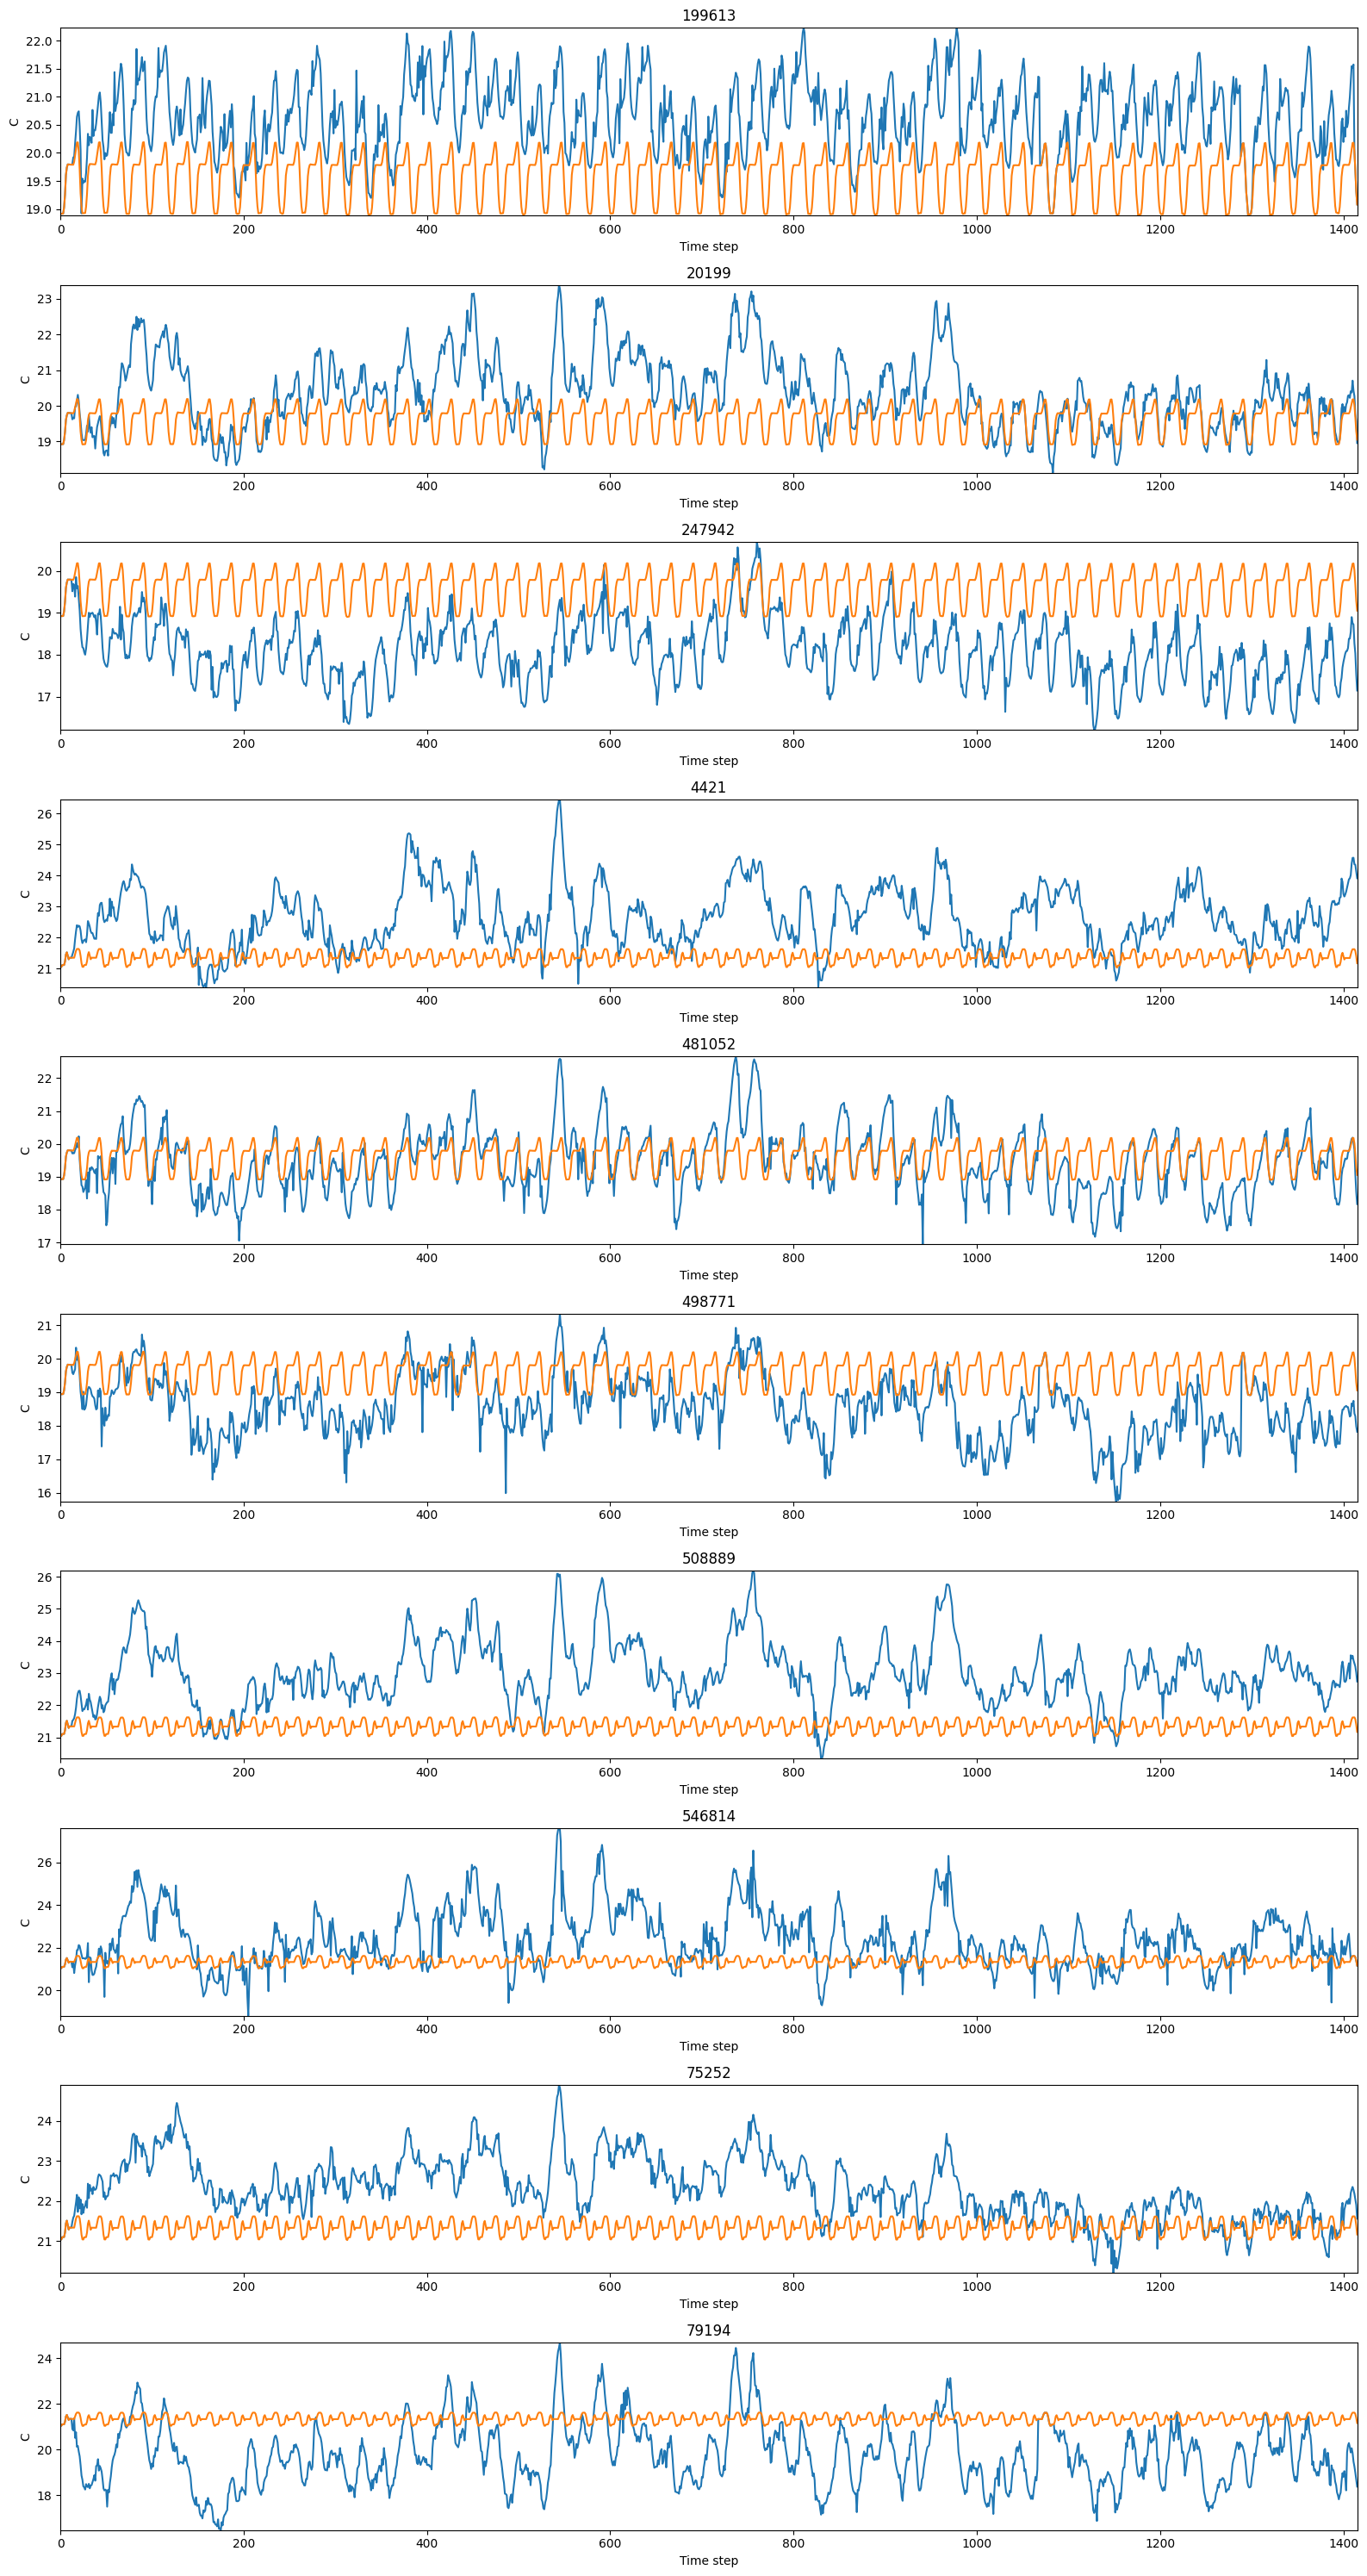

In [5]:
# find building with least LSTM error
plot_data = DataHandler.get_concat_data(['lod_1', 'building_all', 'awc2024'], 'time_series')
building_order_in_schema = list(read_json(os.path.join(FileHandler.SCHEMA_DIRECTORY, 'schema.json'))['buildings'].keys())
building_order_in_schema = pd.DataFrame(building_order_in_schema, columns=['bldg_name'])
building_order_in_schema['bldg_index'] = building_order_in_schema.index
plot_data = plot_data.merge(building_order_in_schema, on='bldg_name', how='left')
plot_data['temperature_delta'] = plot_data['indoor_dry_bulb_temperature'] - plot_data['indoor_dry_bulb_temperature_without_partial_load']
summary_data = plot_data.groupby(['bldg_name', 'bldg_index'])[['temperature_delta']].describe()
summary_data[('temperature_delta', 'absolute_mean')] = summary_data[('temperature_delta', 'mean')].abs()
display(summary_data.sort_values(('temperature_delta', 'absolute_mean')))
buildings = plot_data['bldg_name'].unique()
row_count = len(buildings)
column_count = 1
fig, _ = plt.subplots(row_count, column_count, figsize=(16, 3*row_count))

for i, (ax, (b, bdata)) in enumerate(zip(fig.axes, plot_data.groupby('bldg_name'))):
    x = bdata['time_step'].tolist()
    y1 = bdata['indoor_dry_bulb_temperature'].tolist()
    y2 = bdata['indoor_dry_bulb_temperature_without_partial_load'].tolist()
    ax.plot(x, y1)
    ax.plot(x, y2)
    ax.set_title(b)
    ax.set_xlabel('Time step')
    ax.set_ylabel('C')
    ax.margins(False)

plt.tight_layout()
plt.show()

dict_keys(['lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-4', 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-2', 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-3', 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-0', 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-1'])


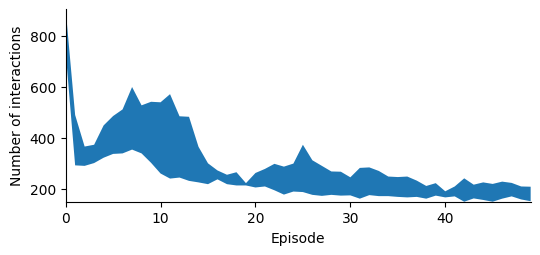

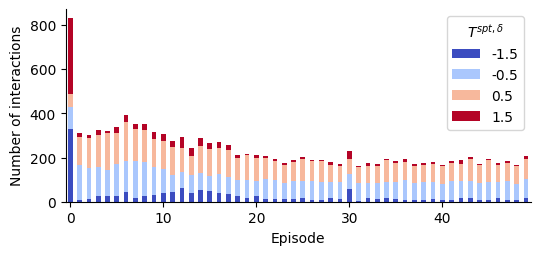

In [21]:
key = 'occupant_interaction_indoor_dry_bulb_temperature_set_point_delta_summary'
data = DataHandler.get_evaluation_summary(['building_3', '-comfortreward-', 'awc2024-o'])
print(data.keys())
delta_data_list = []

for k, v in data.items():
    for i, d in enumerate(v[key][BLDG_NAME][2:-1]):
        d = pd.DataFrame(d).T
        d.columns = ['delta', 'count']
        d['episode'] = i
        d['random_seed'] = v['random_seed']
        delta_data_list.append(d)

delta_data = pd.concat(delta_data_list, ignore_index=True)
delta_data = delta_data[delta_data['delta']!=0.0].copy()

plot_data = delta_data.groupby(['random_seed', 'episode'])[['count']].sum().reset_index()
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
y1 = plot_data.groupby('episode')['count'].min().tolist()
y2 = plot_data.groupby('episode')['count'].max().tolist()
x = range(len(y1))
ax.fill_between(x, y1, y2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_xlabel('Episode')
ax.set_ylabel('Number of interactions')
ax.margins(False)

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
    
plt.savefig(os.path.join(FIGURES_DIRECTORY, f'occupant_interaction_per_episode.png'), bbox_inches='tight', transparent=False)
plt.show()

plot_data = delta_data[delta_data['random_seed']==delta_data['random_seed'].max()].pivot(index='episode', columns='delta', values='count')
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
plot_data.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm')
ax.set_xlabel('Episode')
ax.set_ylabel('Number of interactions')
# ax.margins(False)
ax.tick_params(axis='x', rotation=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.legend(title=r'$T^{spt, \delta}$')

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

plt.savefig(os.path.join(FIGURES_DIRECTORY, f'occupant_setpoint_delta_per_episode.png'), bbox_inches='tight', transparent=False)
plt.show()

['lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-4'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-2'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-3'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-0'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-1'
 'lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-0'
 'lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-1'
 'lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-2'
 'lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-3'
 'lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-4']
Baseline 46.6
Control 63.2


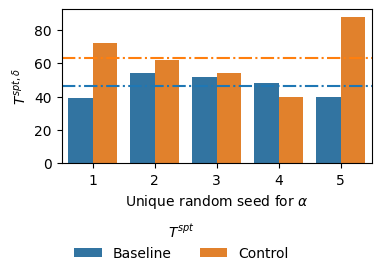

Baseline 10710.655363321304
Control 10736.595994317531


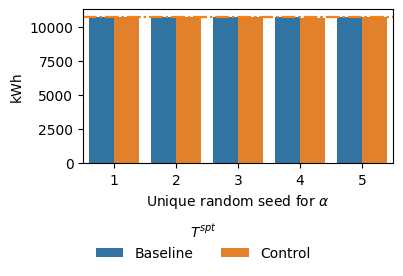

In [268]:
# comparison between lod1 and lod2 interactions
column = 'occupant_interaction_indoor_dry_bulb_temperature_set_point_delta'
data = pd.concat([
    DataHandler.get_concat_data('comfortreward-building_3-final-2022-awc2024-o', 'time_series'),
    DataHandler.get_concat_data('noreward-building_3-final-2022-awc2024', 'time_series'),
], ignore_index=True)
max_random_seed = data.groupby('lod')['random_seed'].max().min()
data = data[(data['random_seed']<=max_random_seed)].copy()
data['label'] = 'Baseline'
data.loc[data['lod']==3, 'label'] = 'Control'
print(data['id'].unique())
palette = {'Baseline': 'tab:blue', 'Control': 'tab:orange'}

plot_data = data[(data[column]!=0)].groupby(['label', 'random_seed'])[[column]].size().reset_index(name='count')
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.barplot(data=plot_data, y='count', x='random_seed', hue='label', palette=palette, ax=ax)

for l, ldata in plot_data.groupby('label'):
    print(l, ldata['count'].mean())
    ax.axhline(ldata['count'].mean(), color=palette[l], linestyle='-.')

ax.set_xlabel('Unique random seed for ' + r'$\alpha$')
ax.set_ylabel(r'$T^{spt, \delta}$')
ax.legend(title=r'$T^{spt}$', loc='upper left', framealpha=0.0, bbox_to_anchor=(0.0, -0.3), ncol=2)
plt.savefig(os.path.join(FIGURES_DIRECTORY, f'occupant_interaction_comparison_per_seed.png'), bbox_inches='tight', transparent=False)
plt.show()

plot_data = data.groupby(['label', 'random_seed'])[['net_electricity_consumption']].sum().reset_index()
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.barplot(data=plot_data, y='net_electricity_consumption', x='random_seed', hue='label', palette=palette, ax=ax)

for l, ldata in plot_data.groupby('label'):
    print(l, ldata['net_electricity_consumption'].mean())
    ax.axhline(ldata['net_electricity_consumption'].mean(), color=palette[l], linestyle='-.')

ax.set_xlabel('Unique random seed for ' + r'$\alpha$')
ax.set_ylabel('kWh')
ax.legend(title=r'$T^{spt}$', loc='upper left', framealpha=0.0, bbox_to_anchor=(0.0, -0.3), ncol=2)
plt.savefig(os.path.join(FIGURES_DIRECTORY, f'net_electricity_consumption_comparison_per_seed.png'), bbox_inches='tight', transparent=False)
plt.show()

['lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-4'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-2'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-3'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-0'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-1'
 'lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-0'
 'lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-1'
 'lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-2'
 'lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-3'
 'lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-4']


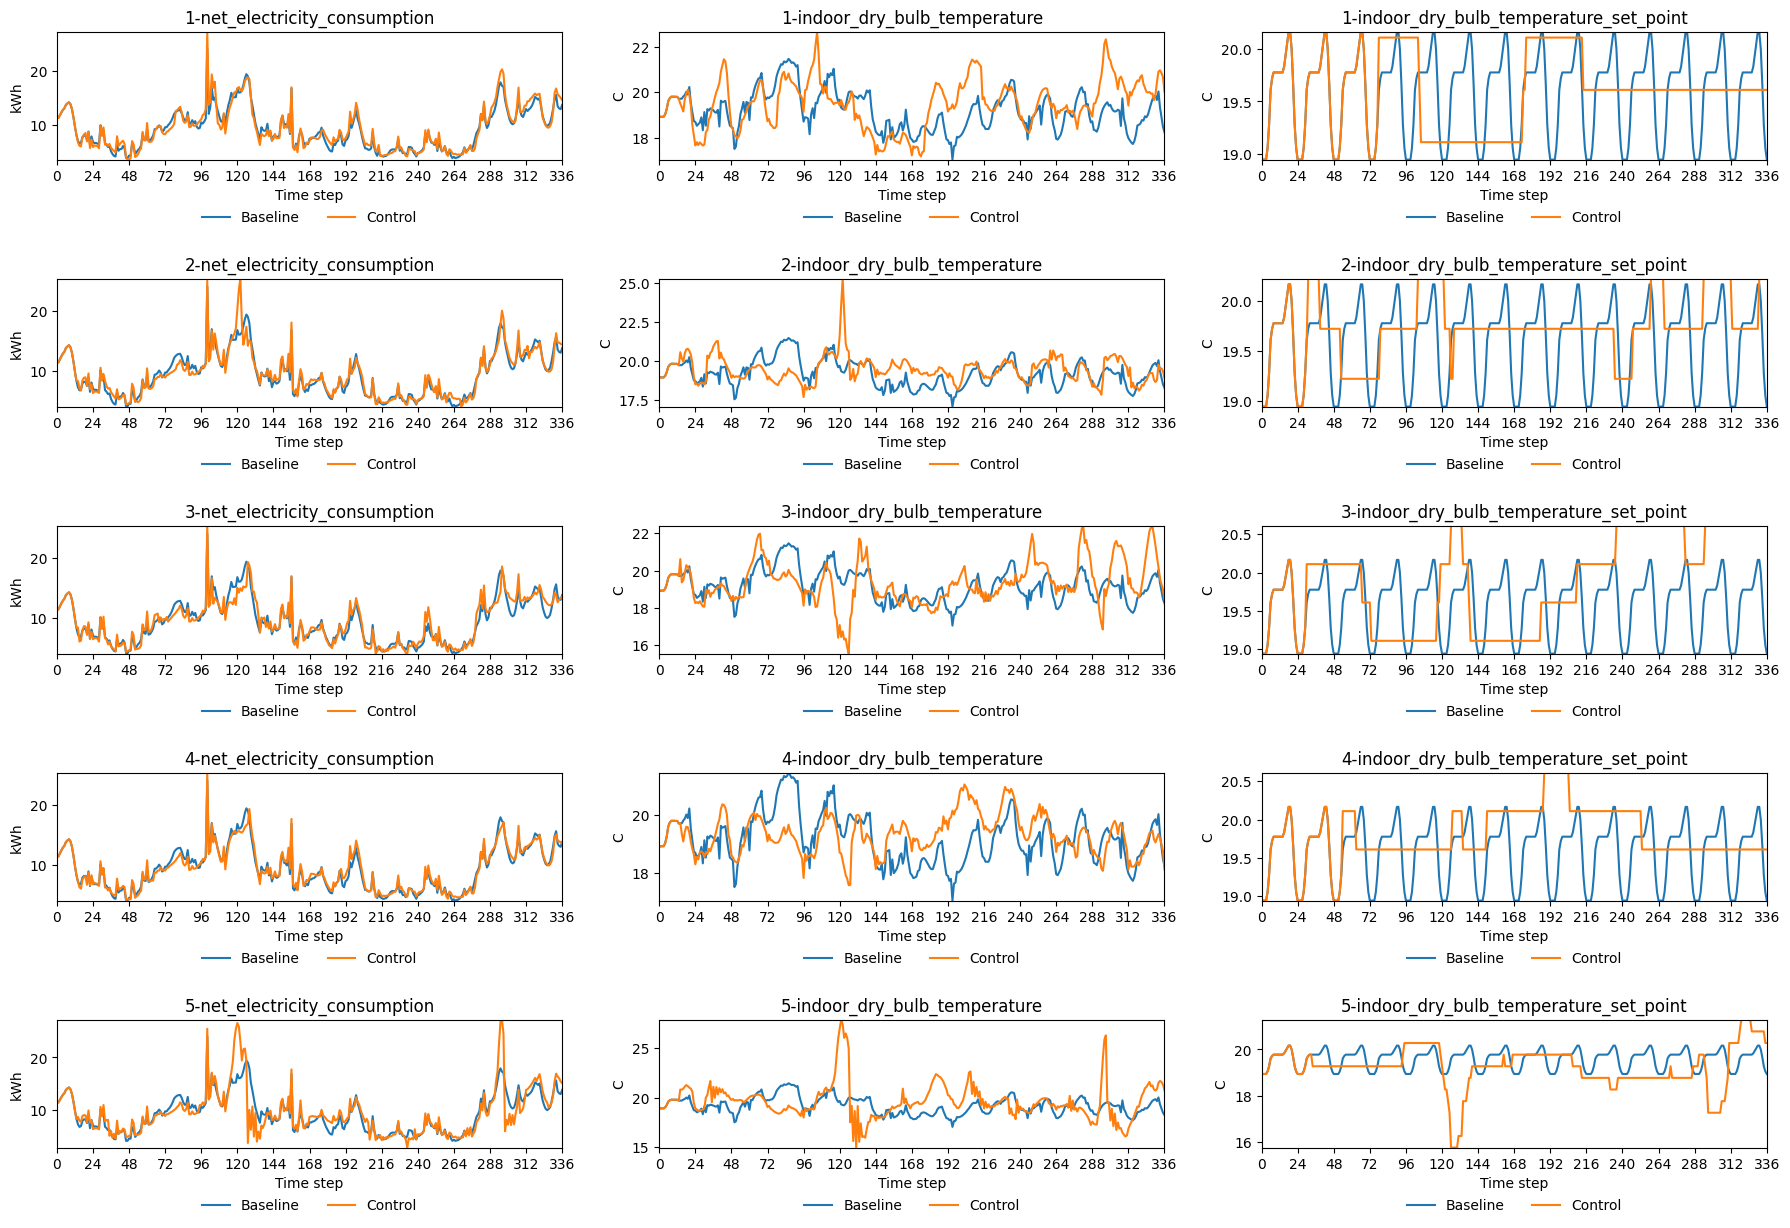

In [19]:
# consumption profile
data = pd.concat([
    DataHandler.get_concat_data('comfortreward-building_3-final-2022-awc2024-o', 'time_series'),
    DataHandler.get_concat_data('noreward-building_3-final-2022-awc2024', 'time_series'),
], ignore_index=True)
start_time_step = 0
end_time_step = int(24*14)
max_random_seed = data.groupby('lod')['random_seed'].max().min()
data = data[(data['random_seed']<=max_random_seed) & (data['time_step']>=start_time_step) & (data['time_step']<=end_time_step)].copy()
columns = ['net_electricity_consumption', 'indoor_dry_bulb_temperature', 'indoor_dry_bulb_temperature_set_point']
column_units = ['kWh', 'C', 'C']
print(data['id'].unique())
data['label'] = 'Baseline'
data.loc[data['lod']==3, 'label'] = 'Control'
row_count = len(data['random_seed'].unique())
column_count = len(columns)
fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 2.5*row_count))
i = 0

for s, sdata in data.groupby('random_seed'):
    for c in columns:
        for l, ldata in sdata.groupby('label'):
            x = ldata['time_step']
            y = ldata[c]
            ax = fig.axes[i]
            ax.plot(x, y, label=l)
            ax.set_xlabel('Time step')
            ax.set_ylabel(column_units[columns.index(c)])
            ax.margins(0)
        
        ax.set_title(f'{s}-{c}')
        ax.legend(loc='upper center', framealpha=0.0, bbox_to_anchor=(0.5, -0.3), ncol=2)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
        i += 1

plt.tight_layout()
plt.show()

['lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-4'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-2'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-3'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-0'
 'lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o-1']
-0.08641340329314552
-0.2808844172989933
-0.5426804177485163
-0.4639497977689749
0.38931208194540234


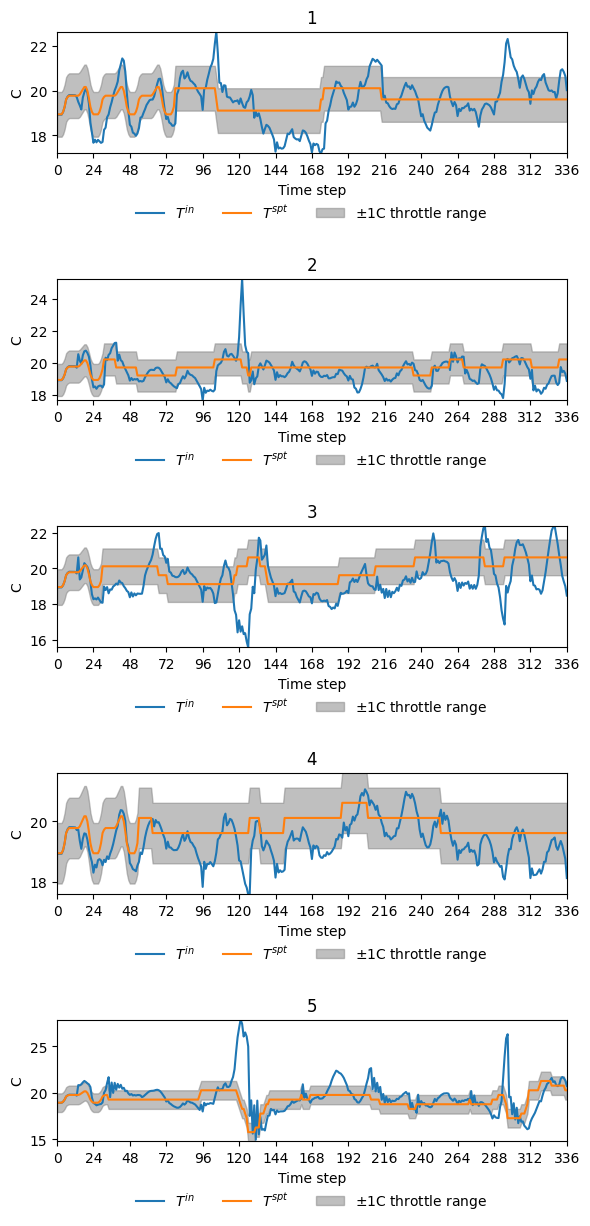

In [27]:
# consumption profile
data = DataHandler.get_concat_data(['lod_3-stable_baselines3-sac-norbc-centralized-comfortreward-building_3-final-2022-awc2024-o'], 'time_series')
start_time_step = 0
end_time_step = int(24*14)
data = data[(data['time_step']>=start_time_step) & (data['time_step']<=end_time_step)].copy()
print(data['id'].unique())
row_count = len(data['random_seed'].unique())
column_count = 1
fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 2.5*row_count))
i = 0

for s, sdata in data.groupby('random_seed'):
    x = sdata['time_step'].tolist()
    print((sdata['indoor_dry_bulb_temperature'] - sdata['indoor_dry_bulb_temperature_set_point']).mean())
    y1 = sdata['indoor_dry_bulb_temperature'].tolist()
    y2 = sdata['indoor_dry_bulb_temperature_set_point'].tolist()
    y3 = (sdata['indoor_dry_bulb_temperature_set_point'] - 1.0).tolist()
    y4 = (sdata['indoor_dry_bulb_temperature_set_point'] + 1.0).tolist()
    ax = fig.axes[i]
    ax.plot(x, y1, label=r'$T^{in}$')
    ax.plot(x, y2, label=r'$T^{spt}$')
    ax.fill_between(x, y3, y4, color='grey', alpha=0.5, label=r'$\pm1$' + 'C throttle range')
    ax.set_xlabel('Time step')
    ax.set_ylabel('C')
    ax.margins(0)
    ax.set_title(f'{s}')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    i += 1
    ax.legend(loc='upper center', framealpha=0.0, bbox_to_anchor=(0.5, -0.3), ncol=3)

plt.tight_layout()
plt.show()

In [146]:
# column = 'occupant_interaction_indoor_dry_bulb_temperature_set_point_delta'
# plot_data = pd.concat([
#     DataHandler.get_concat_data(['building_3', 'awc2024-ecb'], 'time_series'),
# ], ignore_index=True)
# plot_data = plot_data[plot_data[column]!=0].groupby(['id', column])[['time_step']].size().reset_index(name='count')
# display(plot_data.groupby(column)[['count']].agg(['mean', 'std', 'min', 'max']))
# plot_data = plot_data.pivot(index='id', columns=column, values='count')
# fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
# plot_data.plot(kind='bar', stacked=True, colormap='coolwarm_r', ax=ax)
# ax.set_xlabel('Random seed')
# ax.set_ylabel('Time step count')
# ax.margins(False)
# ax.tick_params(axis='x', rotation=90)
# ax.legend(title=r'$\delta$')

# for s in ['right', 'top']:
#     ax.spines[s].set_visible(False)

# plt.show()

In [145]:
# column = 'occupant_interaction_indoor_dry_bulb_temperature_set_point_delta'
# plot_data = DataHandler.get_concat_data(['lod_3', 'building_3', 'awc2024-'], 'time_series')
# plot_data = plot_data[plot_data[column]!=0].groupby(['id', column])[['time_step']].size().reset_index(name='count')
# display(plot_data.groupby(column)[['count']].agg(['mean', 'std', 'min', 'max']))
# plot_data = plot_data.pivot(index='id', columns=column, values='count')
# fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
# plot_data.plot(kind='bar', stacked=True, colormap='coolwarm', ax=ax)
# ax.set_xlabel('Random seed')
# ax.set_ylabel('Time step count')
# ax.margins(False)
# ax.tick_params(axis='x', rotation=90)
# ax.legend(title=r'$\delta$')

# for s in ['right', 'top']:
#     ax.spines[s].set_visible(False)

# plt.show()

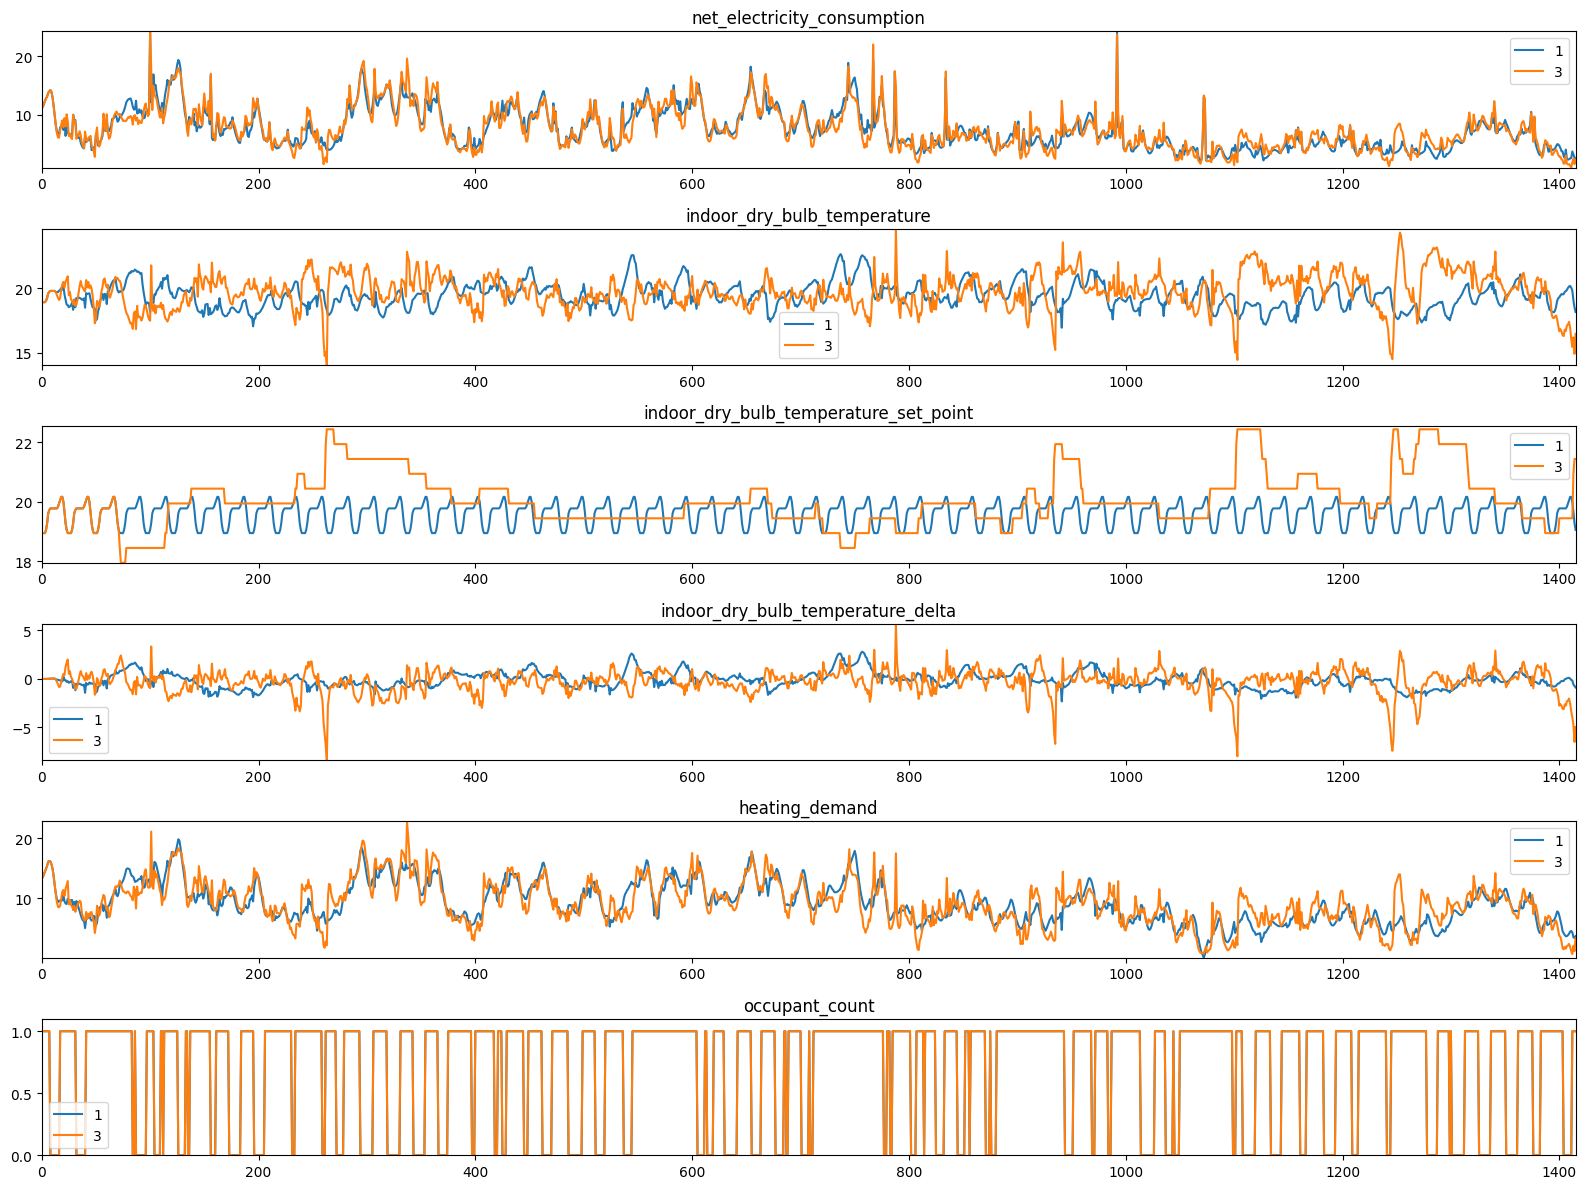

In [179]:
# variable comparisons between lod1 and lod3
variables = ['net_electricity_consumption', 'indoor_dry_bulb_temperature', 'indoor_dry_bulb_temperature_set_point', 'indoor_dry_bulb_temperature_delta', 'heating_demand', 'occupant_count']
plot_data = pd.concat([
    DataHandler.get_concat_data(['-discomfortandsetpointreward-building_3-final-2022-awc2024-2'], 'time_series'), 
    DataHandler.get_concat_data(['lod_1-citylearn-rbc-norbc-centralized-noreward-building_3-final-2022-awc2024-2'
], 'time_series')], ignore_index=True)
plot_data['indoor_dry_bulb_temperature_delta'] = plot_data['indoor_dry_bulb_temperature'] - plot_data['indoor_dry_bulb_temperature_set_point']
plot_data = plot_data[(plot_data['bldg_name']==BLDG_NAME)].melt(
    id_vars=['lod', 'time_step', 'year'],
    value_vars=variables
).sort_values('time_step')
row_count = len(variables)
column_count = 1
fig, _ = plt.subplots(row_count, column_count, figsize=(16, 2*row_count))

for i, (ax, v) in enumerate(zip(fig.axes, variables)):
    for l, ldata in plot_data[plot_data['variable']==v].groupby('lod'):
        x = ldata['time_step'].tolist()
        y = ldata['value'].tolist()
        ax.plot(x, y, label=l)
    
    ax.legend()
    ax.set_title(v)
    ax.margins(False)
    ylim = ax.get_ylim()
    ax.set_ylim(None, ylim[1] + 0.1)

plt.tight_layout()
plt.show()

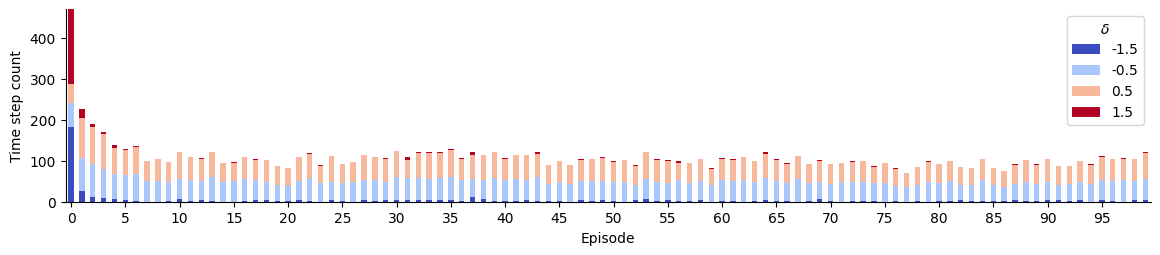

In [180]:
# number of interactions
# simulation_id = data[(data['bldg_name']==BLDG_NAME) & (data['lod']==3)]['id'].iloc[0]
filepath = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/Occupant_Thermostat_Int/simulation/data/citylearn_simulation/lod_3-stable_baselines3-sac-norbc-centralized-discomfortandsetpointreward-building_3-final-2022-awc2024-2.json'
delta_data = read_json(filepath)['occupant_interaction_indoor_dry_bulb_temperature_set_point_delta_summary']
delta_data_list = []

for i, d in enumerate(delta_data[BLDG_NAME][2:-1]):
    d = pd.DataFrame(d).T
    d.columns = ['delta', 'count']
    d['episode'] = i
    delta_data_list.append(d)

delta_data = pd.concat(delta_data_list, ignore_index=True)
plot_data = delta_data[delta_data['delta']!=0.0].copy()
plot_data = plot_data.pivot(index='episode', columns='delta', values='count')
fig, ax = plt.subplots(1, 1, figsize=(14, 2.5))
plot_data.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm')
ax.set_xlabel('Episode')
ax.set_ylabel('Time step count')
ax.margins(False)
ax.tick_params(axis='x', rotation=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
# ax.set_ylim(0, data['time_step'].max() + 1)
ax.legend(title=r'$\delta$')

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

plt.savefig(os.path.join(FIGURES_DIRECTORY, f'occupant_setpoint_delta_per_episode.png'), bbox_inches='tight', transparent=False)
plt.show()

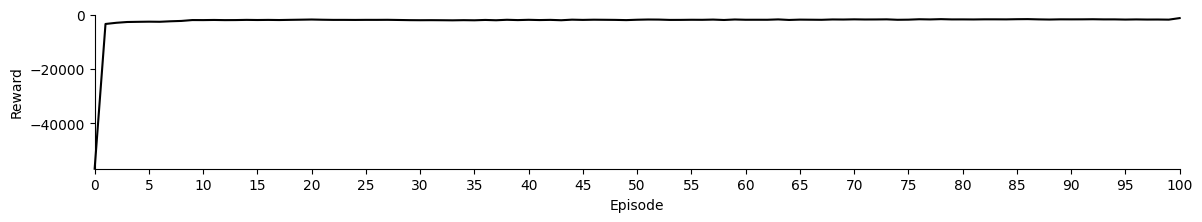

In [183]:
# reward
plot_data = DataHandler.get_concat_data(['-discomfortandsetpointreward-building_3-final-2022-awc2024-2'], 'rewards')
plot_data = plot_data[plot_data['lod']==3].copy().sort_values('episode')
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
x = plot_data['episode'].tolist()
y = plot_data['sum'].tolist()
ax.plot(x, y, clip_on=False, color='black')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.margins(False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_ylim(None, 0)

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

# plt.savefig(os.path.join(FIGURES_DIRECTORY, f'reward_per_episode.png'), bbox_inches='tight', transparent=False)
plt.show()

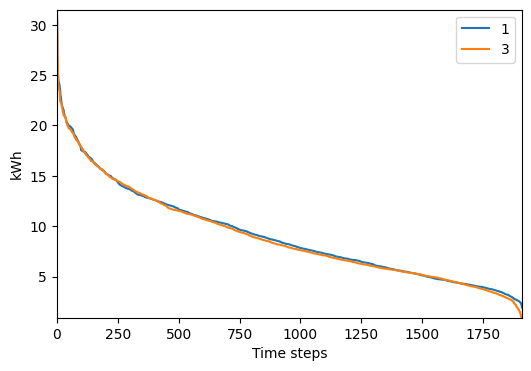

In [23]:
# load duration curve
plot_data = data[(data['bldg_name']==BLDG_NAME) & (data['time_step']>=time_step_start)].copy()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for l, ldata in plot_data.groupby('lod'):
    y = sorted(ldata['net_electricity_consumption'].tolist(), reverse=True)
    x = range(len(y))
    ax.plot(y, label=l)

ax.set_xlabel('Time steps')
ax.set_ylabel('kWh')
ax.margins(False)
ax.legend()
plt.show()

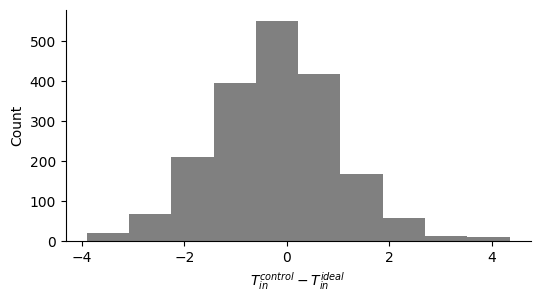

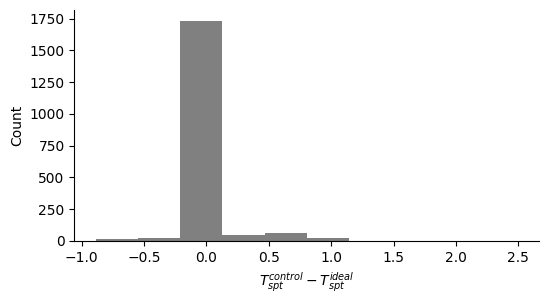

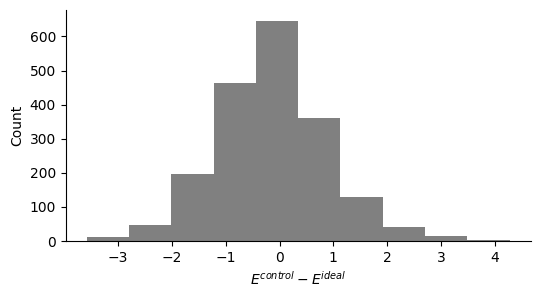

In [37]:
columns = ['indoor_dry_bulb_temperature', 'indoor_dry_bulb_temperature_set_point', 'net_electricity_consumption']
labels = [r'$T_{in}^{control} - T_{in}^{ideal}$', r'$T_{spt}^{control} - T_{spt}^{ideal}$', r'$E^{control} - E^{ideal}$']

for c, l in zip(columns, labels):
    plot_data = data[(data['bldg_name']==BLDG_NAME) & (data['time_step']>=time_step_start)].copy()
    plot_data = plot_data.pivot(index='time_step', columns='lod', values=c)
    plot_data['delta'] = plot_data[3] - plot_data[1]
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    y = plot_data['delta'].tolist()
    ax.hist(y, color='grey')
    ax.set_xlabel(l)
    ax.set_ylabel('Count')

    for s in ['right', 'top']:
        ax.spines[s].set_visible(False)

    plt.savefig(os.path.join(FIGURES_DIRECTORY, f'{c}_difference.png'), bbox_inches='tight', transparent=False)
    plt.show()

- How is the electricity consumption affected?
- How do the number of occupant interactions change per episode, per time step?
- How tolarant is the occupant outside the setpoint?
- How tolerant is the occupant outside lod1 temperature
- How many times does occupant increase/decrease setpoint (this shows that something was actually learned) 
- Scatter plot of temperature vs. setpoint delta

If we can't show reduction in interactions from LOD3 over LOD1, then make a case for the fact that we at least show that model-free RL can learn to reduce interations overtime as well as the magnitude of setpoint change, almost to the same level as the default setpoint schedule. Also note that in LOD1, you have made an assumption

Discussion on reward function, heat pump power and setpoints:
- Up until now, we have taught the agent to maintain comfort by utilizing a reward function that penalizes delta from the setpoint. This is suitable for an environment where heat pump power is controlled and you want to teach the controller to supply just enough power to maintain the setpoint. With the introduction of the occupant model, this approach doesn't work at least not with the current environment-control setup. The reason is comfort and setpoint schedules start to become dissociated. If you reward ability to meet setpoint but comfort lies outside of the defined setpoint schedule, you will run into issues where, you might cause discomfort but because the controller has learnt to maintain 